In [1]:
import os
print(os.getcwd())
# os.chdir('C:\\Users\\u5819317\\Desktop\\Python for QuantEco\\LifeCycle_0')
# print(os.getcwd())

# ======================EGM =========================

## Age 109

In [2]:
import pandas as pd
interestTable = pd.read_csv('return_H.csv', usecols=[1,2,3])  ## Read in interest rate
mortalityTable = pd.read_csv('newmort2.csv', usecols=[1,2,3])  ## Read in mortality table

import numpy as np
from datascience import Table
Expectation = Table.from_df(interestTable)  ## Convert readin csv file to 'table'

β = 1
ρ = 5
grids = 400
Upper_grid = 2000000.0
Lower_grid = Upper_grid / grids

A109 = np.arange(Lower_grid, Upper_grid+1, int(Upper_grid/grids))

Y1 = 85000 # prior retirement income
Y2 = 30000 # post retirement income

import matplotlib.pyplot as plt
%matplotlib inline

def func(θ):
    Expect0 = 1 + θ*Expectation.column('Eq') + (1-θ)*Expectation.column('Bond')
    Expect1 = (Expect0*node + Y2) / node ## scaling here
    Expect2 = np.power(Expect1, -ρ)
    Expect3 = Expectation.column('Eq') - Expectation.column('Bond')
    Expect4 = Expectation.column('Probability') * (Expect2*Expect3)
    return Expect4.sum()

from scipy.optimize import root


θ109 = []
C109 = []
for node in A109:
    sol = root(func, 0.1)  ## 0.1 is the starting point of θ
    θxx = sol.x

    Expect1 = 1 + θxx * Expectation.column('Eq') + (1-θxx) * Expectation.column('Bond')
    Expect2 = node*Expect1 + Y2
    Expect3 = np.power(Expect2, -ρ) * Expect1
    Expect5 = (Expect3 * Expectation.column('Probability')).sum()
    Cxx = np.power(β*(1-mortalityTable['X'][108]) * Expect5, -1/ρ)

    θ109.append(θxx)
    C109.append(Cxx)

θ109 = np.squeeze(θ109)
M109 = A109 - Y2 + C109

print('Optimal risky assets allocation rate at 109 is ' + str(θ109))
print('Optimal consumption at 109 is ' + str(C109))

Optimal risky assets allocation rate at 109 is [1.94058987 1.15855953 0.89815375 0.76808141 0.69010877 0.6381687
 0.60109477 0.57330651 0.55170518 0.53443242 0.52030621 0.50853885
 0.49858527 0.49005625 0.48266649 0.47620209 0.47049952 0.46543165
 0.46089812 0.45681866 0.45312834 0.44977402 0.44671181 0.44390516
 0.44132336 0.43894043 0.43673426 0.43468588 0.43277895 0.43099931
 0.42933463 0.42777412 0.42630829 0.42492879 0.42362821 0.42239996
 0.42123818 0.4201376  0.41909353 0.41810172 0.41715833 0.41625991
 0.41540332 0.4145857  0.41380446 0.41305721 0.41234179 0.4116562
 0.41099863 0.41036738 0.4097609  0.40917777 0.40861666 0.40807635
 0.40755571 0.40705367 0.40656926 0.40610157 0.40564975 0.40521299
 0.40479057 0.40438178 0.40398598 0.40360256 0.40323094 0.4028706
 0.40252101 0.40218172 0.40185226 0.40153222 0.40122121 0.40091884
 0.40062476 0.40033863 0.40006014 0.39978898 0.39952487 0.39926753
 0.39901671 0.39877217 0.39853366 0.39830098 0.39807391 0.39785225
 0.3976358  0.3974

## Age 108-65

In [3]:
import time
start_time = time.time()  ## Calculate the time needed to run the calculation
Optimal_results_EGM = Table().with_columns([
    'A109', A109,
    'C109', C109,
    'M109', M109,
])

Optimal_θx = Table().with_columns([
    'θ109', θ109,
])
from scipy.interpolate import interp1d

for i in range(44): ## age 108-65 --> i from 0 to 43 (include)
    Ax = A109    
    Optimal_results_EGM = Optimal_results_EGM.with_column('A%(age)1d'%{'age':108-i}, Ax)
    
    def theta(x):
        Interpo1 = 1 + (1-x)*Expectation.column('Bond') + x*Expectation.column('Eq')
        Interpo2 = node * Interpo1  ## node is the value for each Mx
    
        Interpolation = interp1d(Optimal_results_EGM.column(3*i+2), Optimal_results_EGM.column(3*i+1), \
                                 kind='linear', fill_value='extrapolate')
        Interpo3 = Interpolation(Interpo2) / Optimal_results_EGM.column(3*i+1)[Ax==node] 
                   ## Divided by a constant here and get a value close to 1, for later take power of -ρ.
        Interpo4 = np.power(Interpo3, -ρ) * (Expectation.column('Eq') - Expectation.column('Bond'))
        Interpo5 = (Expectation.column('Probability') * Interpo4).sum()
        return(Interpo5)

    θx = []
    for node in Ax:
        solution = root(theta, 0.1)
        θ = float(solution.x)
        if θ <= 0: ## Constraint
            θ = 0
        elif θ >= 1:
            θ = 1
        θx.append(θ)
    Optimal_θx = Optimal_θx.with_column('θ%(age)1d'%{'age':108-i},θx)    
    
    
    Cx = []
    for index, node in enumerate(Ax):
        cal1 = 1 + (1-θx[index])*Expectation.column('Bond') + θx[index]*Expectation.column('Eq')
        cal2 = node * cal1
        Interpolation = interp1d(Optimal_results_EGM.column(3*i+2), Optimal_results_EGM.column(3*i+1), \
                                 kind='linear', fill_value='extrapolate')
        cal3 = Interpolation(cal2)
        cal4 = np.power(cal3, -ρ) * cal1 * Expectation.column('Probability')
        cal5 = cal4.sum()
        cal6 = np.power(cal5 * (1-mortalityTable['X'][107-i]), -1/ρ)
        Cx.append(cal6)
    Optimal_results_EGM = Optimal_results_EGM.with_column('C%(age)1d'%{'age':108-i},Cx)

    Mx = Ax - Y2 + Cx
    Optimal_results_EGM = Optimal_results_EGM.with_column('M%(age)1d'%{'age':108-i},Mx)

print("--- %s seconds ---" % (time.time() - start_time))

Optimal_results_EGM.show(3)

--- 21.89038372039795 seconds ---


A109,C109,M109,A108,C108,M108,A107,C107,M107,A106,C106,M106,A105,C105,M105,A104,C104,M104,A103,C103,M103,A102,C102,M102,A101,C101,M101,A100,C100,M100,A99,C99,M99,A98,C98,M98,A97,C97,M97,A96,C96,M96,A95,C95,M95,A94,C94,M94,A93,C93,M93,A92,C92,M92,A91,C91,M91,A90,C90,M90,A89,C89,M89,A88,C88,M88,A87,C87,M87,A86,C86,M86,A85,C85,M85,A84,C84,M84,A83,C83,M83,A82,C82,M82,A81,C81,M81,A80,C80,M80,A79,C79,M79,A78,C78,M78,A77,C77,M77,A76,C76,M76,A75,C75,M75,A74,C74,M74,A73,C73,M73,A72,C72,M72,A71,C71,M71,A70,C70,M70,A69,C69,M69,A68,C68,M68,A67,C67,M67,A66,C66,M66,A65,C65,M65
5000,39058,14058,5000,37705.8,12705.8,5000,38063.1,13063.1,5000,38772.9,13772.9,5000,39552.6,14552.6,5000,40303.8,15303.8,5000,40981.3,15981.3,5000,41580.2,16580.2,5000,42090.3,17090.3,5000,42502.6,17502.6,5000,42810.1,17810.1,5000,43047,18047,5000,43187.4,18187.4,5000,43215.7,18215.7,5000,43125.1,18125.1,5000,42915.7,17915.7,5000,42593.7,17593.7,5000,42170.4,17170.4,5000,41661.1,16661.1,5000,41084,16084,5000,40458.8,15458.8,5000,39802.8,14802.8,5000,39129.8,14129.8,5000,38451.2,13451.2,5000,37776.1,12776.1,5000,37111.5,12111.5,5000,36463.1,11463.1,5000,35834.9,10834.9,5000,35230.1,10230.1,5000,34650.8,9650.76,5000,34098.1,9098.1,5000,33572.7,8572.73,5000,33074.6,8074.65,5000,32603.4,7603.38,5000,32158.3,7158.32,5000,31738.8,6738.76,5000,31343.9,6343.92,5000,30972.9,5972.93,5000,30624.8,5624.83,5000,30298.6,5298.62,5000,29993.2,4993.18,5000,29707.3,4707.33,5000,29439.8,4439.81,5000,29189.3,4189.27,5000,28954.3,3954.33
10000,44819.5,24819.5,10000,40865.2,20865.2,10000,40347,20347,10000,40618.6,20618.6,10000,41135.4,21135.4,10000,41711,21711,10000,42262.2,22262.2,10000,42765.9,22765.9,10000,43201.3,23201.3,10000,43552.7,23552.7,10000,43809.3,23809.3,10000,44003.1,24003.1,10000,44105.9,24105.9,10000,44100.5,24100.5,10000,43978.6,23978.6,10000,43740,23740,10000,43390.2,23390.2,10000,42940.4,22940.4,10000,42405.6,22405.6,10000,41804.1,21804.1,10000,41155.8,21155.8,10000,40477.8,20477.8,10000,39784.1,19784.1,10000,39086,19086,10000,38392.5,18392.5,10000,37710.8,17710.8,10000,37046.3,17046.3,10000,36403.1,16403.1,10000,35784.3,15784.3,10000,35191.9,15191.9,10000,34627.2,14627.2,10000,34090.5,14090.5,10000,33582,13582,10000,33101,13101,10000,32646.9,12646.9,10000,32219,12219,10000,31816.4,11816.4,10000,31438.1,11438.1,10000,31083.3,11083.3,10000,30750.7,10750.7,10000,30439.3,10439.3,10000,30147.8,10147.8,10000,29874.9,9874.85,10000,29619.1,9619.09,10000,29379.1,9379.11
15000,50576.8,35576.8,15000,44005.8,29005.8,15000,42620.3,27620.3,15000,42457.2,27457.2,15000,42712.9,27712.9,15000,43113.9,28113.9,15000,43539.7,28539.7,15000,43948.7,28948.7,15000,44309.7,29309.7,15000,44600.6,29600.6,15000,44806.4,29806.4,15000,44957.4,29957.4,15000,45022.8,30022.8,15000,44983.6,29983.6,15000,44830.7,29830.7,15000,44562.8,29562.8,15000,44185.4,29185.4,15000,43709.1,28709.1,15000,43148.9,28148.9,15000,42523.2,27523.2,15000,41851.7,26851.7,15000,41151.8,26151.8,15000,40437.4,25437.4,15000,39719.8,24719.8,15000,39008,24008,15000,38309.1,23309.1,15000,37628.6,22628.6,15000,36970.4,21970.4,15000,36337.6,21337.6,15000,35732.2,20732.2,15000,35155.2,20155.2,15000,34607.3,19607.3,15000,34088.2,19088.2,15000,33597.4,18597.4,15000,33134.2,18134.2,15000,32697.7,17697.7,15000,32287.1,17287.1,15000,31901.4,16901.4,15000,31539.4,16539.4,15000,31200.2,16200.2,15000,30882.4,15882.4,15000,30584.9,15584.9,15000,30306.2,15306.2,15000,30044.8,15044.8,15000,29799.5,14799.5


In [4]:
Optimal_θx.show(3)

θ109,θ108,θ107,θ106,θ105,θ104,θ103,θ102,θ101,θ100,θ99,θ98,θ97,θ96,θ95,θ94,θ93,θ92,θ91,θ90,θ89,θ88,θ87,θ86,θ85,θ84,θ83,θ82,θ81,θ80,θ79,θ78,θ77,θ76,θ75,θ74,θ73,θ72,θ71,θ70,θ69,θ68,θ67,θ66,θ65
1.94059,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1.15856,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
0.898154,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


## Age 64

In [5]:
A64 = A109 
# θ64 = [0.5] * grids

def theta64(x):
    Interpo1 = 1 + (1-x)*Expectation.column('Bond') + x*Expectation.column('Eq')
    Interpo2 = node * Interpo1  ## node is the value for each Mx

    Interpolation = interp1d(Optimal_results_EGM.column(3*43+2), Optimal_results_EGM.column(3*43+1), \
                             kind='linear', fill_value='extrapolate')
    Interpo3 = Interpolation(Interpo2) / Optimal_results_EGM.column(3*43+1)[Ax==node] ## do a scaling here
               ## Divided by a constant here and get a value close to 1, for later take power of -ρ.
    Interpo4 = np.power(Interpo3, -ρ) * (Expectation.column('Eq') - Expectation.column('Bond'))
    Interpo5 = (Expectation.column('Probability') * Interpo4).sum()
    return(Interpo5)

θ64 = []
for node in Ax:
    solution = root(theta64, 0.1)
    θ = float(solution.x)
    if θ <= 0: ## Constraint
        θ = 0
    elif θ >= 1:
        θ = 1
    θ64.append(θ)

C64 = []
C_un64 = []
for index, node in enumerate(Ax):
    cal1 = 1 + (1-θ64[index])*Expectation.column('Bond') + θ64[index]*Expectation.column('Eq')
    cal2 = node * cal1
    Interpolation = interp1d(Optimal_results_EGM.column('M65'), Optimal_results_EGM.column('C65'),\
                             kind='linear', fill_value='extrapolate')
    cal3 = Interpolation(cal2)
    cal4 = np.power(cal3, -ρ) * cal1 * Expectation.column('Probability')
    cal5 = cal4.sum()
    cal6 = np.power(cal5 * β * (1-mortalityTable['X'][63]), -1/ρ)
    C_un = cal6
    
    if cal6 > Y1:
        cal6 = Y1
#         Deriv1 = cal6 ** (-ρ)
#         Deriv2 = β * (1-mortalityTable['X'][63]) * cal4.sum()
#         λ = Deriv1 - Deriv2
#     else:
#         λ = 0
    C64.append(cal6)
    C_un64.append(C_un)
M64 = A64 - Y1 + C64

Optimal_results_EGM_64 = Table().with_columns([
    'A64', A64,                           
    'C64', C64,
    'M64', M64,
    'C_un64', C_un64,
])

Optimal_results_EGM_64.show(3)

A64,C64,M64,C_un64
5000,28733.7,-51266.3,28733.7
10000,29153.6,-45846.4,29153.6
15000,29568.8,-40431.2,29568.8


## Age 63-25

In [6]:
import time
start_time = time.time()

Optimal_results_EGM_25_63 = Table().with_columns([ ## Collect the results into a table
    'A64', Optimal_results_EGM_64.column('A64'),
    'C64', Optimal_results_EGM_64.column('C64'),
    'M64', Optimal_results_EGM_64.column('M64'),
    'C_un64', Optimal_results_EGM_64.column('C_un64'),
])
Optimal_θx_25_63 = Table().with_columns([
    'θ64', θ64,
])

for i in range(39): ## age 63-25 --> i from 0 to 38 (include)
    
    Ax = A109    
    Optimal_results_EGM_25_63 = Optimal_results_EGM_25_63.with_column('A%(age)1d'%{'age':63-i},Ax)
#     θx = [0.5] * grids

    def thetaX(x):
        Interpo1 = 1 + (1-x)*Expectation.column('Bond') + x*Expectation.column('Eq')
        Interpo2 = node * Interpo1
        Interpolation = interp1d(Optimal_results_EGM_25_63.column(4*i+2), Optimal_results_EGM_25_63.column(4*i+3), \
                                 kind='linear', fill_value='extrapolate')
        Interpo3 = Interpolation(Interpo2) / Optimal_results_EGM_25_63.column(4*i+1)[Ax==node]
        Interpo4 = np.power(Interpo3, -ρ) * (Expectation.column('Eq') - Expectation.column('Bond'))
        Interpo5 = (Expectation.column('Probability') * Interpo4).sum()
        return(Interpo5)

    θx = []
    for node in Ax:
        solution = root(thetaX, 0.1)
        θ = float(solution.x)
        if θ <= 0: ## Constraint
            θ = 0
        elif θ >= 1:
            θ = 1
        θx.append(θ)
    Optimal_θx_25_63 = Optimal_θx_25_63.with_column('θ%(age)1d'%{'age':63-i},θx)
    
    Cx = []
    C_unx = []
    for index, node in enumerate(Ax):
        cal1 = 1 + (1-θx[index])*Expectation.column('Bond') + θx[index]*Expectation.column('Eq')
        cal2 = node * cal1
        Interpolation_C = interp1d(Optimal_results_EGM_25_63.column(4*i+2), Optimal_results_EGM_25_63.column(4*i+3),\
                                 kind='linear', fill_value='extrapolate')
        cal3 = Interpolation_C(cal2)
        cal4 = (np.power(cal3, -ρ) - 0) * cal1 * Expectation.column('Probability')
        cal5 = cal4.sum()
        cal6 = np.power(cal5 * (1-mortalityTable['X'][62-i]), -1/ρ)
        C_un = cal6
        
        if cal6 > Y1:
            cal6 = Y1
        Cx.append(cal6)
        C_unx.append(C_un)

    Optimal_results_EGM_25_63 = Optimal_results_EGM_25_63.with_column('C%(age)1d'%{'age':63-i},Cx)
    Mx = Ax - Y1 + Cx
    Optimal_results_EGM_25_63 = Optimal_results_EGM_25_63.with_column('M%(age)1d'%{'age':63-i},Mx)
    Optimal_results_EGM_25_63 = Optimal_results_EGM_25_63.with_column('C_un%(age)1d'%{'age':63-i},C_unx)

print("--- %s seconds ---" % (time.time() - start_time))

Optimal_results_EGM_25_63.show(3)

--- 19.10194969177246 seconds ---


A64,C64,M64,C_un64,A63,C63,M63,C_un63,A62,C62,M62,C_un62,A61,C61,M61,C_un61,A60,C60,M60,C_un60,A59,C59,M59,C_un59,A58,C58,M58,C_un58,A57,C57,M57,C_un57,A56,C56,M56,C_un56,A55,C55,M55,C_un55,A54,C54,M54,C_un54,A53,C53,M53,C_un53,A52,C52,M52,C_un52,A51,C51,M51,C_un51,A50,C50,M50,C_un50,A49,C49,M49,C_un49,A48,C48,M48,C_un48,A47,C47,M47,C_un47,A46,C46,M46,C_un46,A45,C45,M45,C_un45,A44,C44,M44,C_un44,A43,C43,M43,C_un43,A42,C42,M42,C_un42,A41,C41,M41,C_un41,A40,C40,M40,C_un40,A39,C39,M39,C_un39,A38,C38,M38,C_un38,A37,C37,M37,C_un37,A36,C36,M36,C_un36,A35,C35,M35,C_un35,A34,C34,M34,C_un34,A33,C33,M33,C_un33,A32,C32,M32,C_un32,A31,C31,M31,C_un31,A30,C30,M30,C_un30,A29,C29,M29,C_un29,A28,C28,M28,C_un28,A27,C27,M27,C_un27,A26,C26,M26,C_un26,A25,C25,M25,C_un25
5000,28733.7,-51266.3,28733.7,5000,32535.6,-47464.4,32535.6,5000,35681.7,-44318.3,35681.7,5000,38369.4,-41630.6,38369.4,5000,40703.1,-39296.9,40703.1,5000,42759,-37241,42759,5000,44604.9,-35395.1,44604.9,5000,46277.7,-33722.3,46277.7,5000,47804.9,-32195.1,47804.9,5000,49205.4,-30794.6,49205.4,5000,50493.7,-29506.3,50493.7,5000,51681.8,-28318.2,51681.8,5000,52779.6,-27220.4,52779.6,5000,53795.6,-26204.4,53795.6,5000,54737,-25263,54737,5000,55610.6,-24389.4,55610.6,5000,56422.5,-23577.5,56422.5,5000,57178.1,-22821.9,57178.1,5000,57882.9,-22117.1,57882.9,5000,58541.8,-21458.2,58541.8,5000,59159.3,-20840.7,59159.3,5000,59739.6,-20260.4,59739.6,5000,60286.7,-19713.3,60286.7,5000,60804,-19196,60804,5000,61294.8,-18705.2,61294.8,5000,61761.7,-18238.3,61761.7,5000,62207.4,-17792.6,62207.4,5000,62633.9,-17366.1,62633.9,5000,63043.3,-16956.7,63043.3,5000,63437.3,-16562.7,63437.3,5000,63817.2,-16182.8,63817.2,5000,64184.4,-15815.6,64184.4,5000,64540,-15460,64540,5000,64884.9,-15115.1,64884.9,5000,65220,-14780,65220,5000,65546.1,-14453.9,65546.1,5000,65863.7,-14136.3,65863.7,5000,66173.6,-13826.4,66173.6,5000,66476.3,-13523.7,66476.3,5000,66772.2,-13227.8,66772.2
10000,29153.6,-45846.4,29153.6,10000,32912.2,-42087.8,32912.2,10000,36031,-38969,36031,10000,38699,-36301,38699,10000,41017,-33983,41017,10000,43063,-31937,43063,10000,44902,-30098,44902,10000,46570,-28430,46570,10000,48093.5,-26906.5,48093.5,10000,49491.1,-25508.9,49491.1,10000,50777.3,-24222.7,50777.3,10000,51963.7,-23036.3,51963.7,10000,53060,-21940,53060,10000,54074.8,-20925.2,54074.8,10000,55015.4,-19984.6,55015.4,10000,55888.3,-19111.7,55888.3,10000,56699.7,-18300.3,56699.7,10000,57455.2,-17544.8,57455.2,10000,58160.2,-16839.8,58160.2,10000,58819.5,-16180.5,58819.5,10000,59437.7,-15562.3,59437.7,10000,60019.2,-14980.8,60019.2,10000,60567.7,-14432.3,60567.7,10000,61086.8,-13913.2,61086.8,10000,61579.6,-13420.4,61579.6,10000,62048.9,-12951.1,62048.9,10000,62497.2,-12502.8,62497.2,10000,62926.6,-12073.4,62926.6,10000,63339.1,-11660.9,63339.1,10000,63736.4,-11263.6,63736.4,10000,64119.8,-10880.2,64119.8,10000,64490.8,-10509.2,64490.8,10000,64850.3,-10149.7,64850.3,10000,65199.3,-9800.72,65199.3,10000,65538.6,-9461.36,65538.6,10000,65869.1,-9130.91,65869.1,10000,66191.3,-8808.69,66191.3,10000,66505.9,-8494.11,66505.9,10000,66813.3,-8186.65,66813.3,10000,67114.2,-7885.81,67114.2
15000,29568.8,-40431.2,29568.8,15000,33285.3,-36714.7,33285.3,15000,36377.5,-33622.5,36377.5,15000,39026.2,-30973.8,39026.2,15000,41328.9,-28671.1,41328.9,15000,43365.3,-26634.7,43365.3,15000,45197.7,-24802.3,45197.7,15000,46861,-23139,46861,15000,48380.9,-21619.1,48380.9,15000,49775.8,-20224.2,49775.8,15000,51059.8,-18940.2,51059.8,15000,52244.4,-17755.6,52244.4,15000,53339.3,-16660.7,53339.3,15000,54353,-15647,54353,15000,55292.6,-14707.4,55292.6,15000,56164.9,-13835.1,56164.9,15000,56975.9,-13024.1,56975.9,15000,57731.3,-12268.7,57731.3,15000,58436.4,-11563.6,58436.4,15000,59096.2,-10903.8,59096.2,15000,59715.2,-10284.8,59715.2,15000,60297.8,-9702.15,60297.8,15000,60847.9,-9152.13,60847.9,15000,61368.8,-8631.22,61368.8,15000,61863.7,-8136.29,61863.7,15000,62335.4,-7664.56,62335.4,15000,62786.4,-7213.58,62786.4,15000,63218.8,-6781.18,63218.8,15000,63634.5,-6

In [7]:
Optimal_θx_25_63.show(3)

θ64,θ63,θ62,θ61,θ60,θ59,θ58,θ57,θ56,θ55,θ54,θ53,θ52,θ51,θ50,θ49,θ48,θ47,θ46,θ45,θ44,θ43,θ42,θ41,θ40,θ39,θ38,θ37,θ36,θ35,θ34,θ33,θ32,θ31,θ30,θ29,θ28,θ27,θ26,θ25
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


# ======================VFI =========================

In [8]:
## Initial setting
M110 = np.arange(Lower_grid, Upper_grid+1, int(Upper_grid/grids))
# interest = (1-θ)*Expectation.column('Bond') + θ*Expectation.column('Eq')

C110 = M110 + Y2
# L110 = [1] * (grids)
V110 = np.power(C110, 1-ρ) / (1-ρ)
V110_adj = np.power(V110*(1-ρ),1/(1-ρ))

A110 = M110 - C110

Optimal_results_VFI = Table().with_columns([
    'M110', M110,
    'C110', C110,
    'A110', A110,
    'V110', V110,
    'V110_adj', V110_adj,
])

Optimal_results_VFI.show(3)

M110,C110,A110,V110,V110_adj
5000,35000,-30000,-1.66597e-19,35000
10000,40000,-30000,-9.76562e-20,40000
15000,45000,-30000,-6.09663e-20,45000


# Age 109-65

In [9]:
from scipy.interpolate import interp1d
from scipy import optimize

def value_funtion(control_variables):
    C, θ = control_variables
    interest = (1-θ)*Expectation.column('Bond') + θ*Expectation.column('Eq')
    value1 = np.power(C, 1-ρ) / (1-ρ) # this is negative
    M_next = (node + Y2 - C) * (1+interest) # now it becomes a vector
    value2 = β * (1-mortalityTable['X'][108-i]) * interpo(M_nt=M_next, table=Optimal_results_VFI)
    Ex_value2 = (value2 * Expectation.column('Probability')).sum()
    return - (value1 + Ex_value2) * 1e18 ## To minimise, use negative results

def utility(C):
    u = np.power(C, 1-ρ) / (1-ρ)
    return u

def transform(x):
    T = np.power(x*(1-ρ), 1/(1-ρ))
    return T

def solve():
    return optimize.minimize(value_funtion, initial_guess, method='SLSQP', tol=None, bounds = [(0,node+Y2), (0,1)], \
                            options={'maxiter':100, 'ftol':1e-20})  # method='L-BFGS-B'; method='SLSQP'


In [10]:
import time
start_time = time.time()

Start_bal = Table()
for i in range(45):
    Start_bal = Start_bal.with_column('M%1d'%(109-i), Optimal_results_EGM.column(3*i+2))

Optimal_results_VFI = Table().with_columns([
    'M110', M110,
    'C110', C110,
    'A110', A110,
    'V110', V110,
    'V110_adj', V110_adj,
])
Optimal_θx_VFI = Table()

for i in range(45): ## age 109-65 --> i from 0 to 44 (include)
    
    def interpo(M_nt, table): # need to know which table to use
        func = interp1d(table.column(5*i+0), table.column(5*i+4), kind='linear', fill_value='extrapolate')
        V_next_adj = func(M_nt) 
        V_next = utility(V_next_adj)
        return V_next
    
    Mx = Start_bal.column(i)
    Optimal_results_VFI = Optimal_results_VFI.with_column('M%(age)1d'%{'age':109-i}, Mx)

    Cx = []
    θx = []
    
    Ax = []
    Vx = []
    Vx_adj = []
    for node in Mx:
        guess_con = 5000.0
        guess_theta = 0.1
        initial_guess = [guess_con, guess_theta]
        opt = solve()
        
        while not opt.success:
            guess_con += 500
            initial_guess = [guess_con, guess_theta]
            opt = solve()
            
        Cxx, θxx = opt.x
        Cx.append(Cxx)
        θx.append(θxx)
        
        Axx = node - Cxx + Y2
        Ax.append(Axx)
        Vxx = - opt.fun / 1e18 # to minimize, previous use negative value function
        Vx.append(Vxx)
        Vxx_adj = transform(Vxx)
        Vx_adj.append(Vxx_adj)

    Optimal_θx_VFI = Optimal_θx_VFI.with_column('θ%(age)1d'%{'age':109-i}, θx)
    Optimal_results_VFI = Optimal_results_VFI.with_column('C%(age)1d'%{'age':109-i}, Cx)
    Optimal_results_VFI = Optimal_results_VFI.with_column('A%(age)1d'%{'age':109-i}, Ax)
    Optimal_results_VFI = Optimal_results_VFI.with_column('V%(age)1d'%{'age':109-i}, Vx)
    Optimal_results_VFI = Optimal_results_VFI.with_column('V%(age)1d_adj'%{'age':109-i}, Vx_adj)
    print('age%1d_finished!'%(109-i))

print("--- %s seconds ---" % (time.time() - start_time))

Optimal_results_VFI.show(3)

age109_finished!
age108_finished!


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in power
  import sys


age107_finished!
age106_finished!
age105_finished!
age104_finished!
age103_finished!
age102_finished!
age101_finished!
age100_finished!
age99_finished!
age98_finished!
age97_finished!
age96_finished!
age95_finished!
age94_finished!
age93_finished!
age92_finished!
age91_finished!
age90_finished!
age89_finished!
age88_finished!
age87_finished!
age86_finished!
age85_finished!
age84_finished!
age83_finished!
age82_finished!
age81_finished!
age80_finished!
age79_finished!
age78_finished!
age77_finished!
age76_finished!
age75_finished!
age74_finished!
age73_finished!
age72_finished!
age71_finished!
age70_finished!
age69_finished!
age68_finished!
age67_finished!
age66_finished!
age65_finished!
--- 688.4223396778107 seconds ---


M110,C110,A110,V110,V110_adj,M109,C109,A109,V109,V109_adj,M108,C108,A108,V108,V108_adj,M107,C107,A107,V107,V107_adj,M106,C106,A106,V106,V106_adj,M105,C105,A105,V105,V105_adj,M104,C104,A104,V104,V104_adj,M103,C103,A103,V103,V103_adj,M102,C102,A102,V102,V102_adj,M101,C101,A101,V101,V101_adj,M100,C100,A100,V100,V100_adj,M99,C99,A99,V99,V99_adj,M98,C98,A98,V98,V98_adj,M97,C97,A97,V97,V97_adj,M96,C96,A96,V96,V96_adj,M95,C95,A95,V95,V95_adj,M94,C94,A94,V94,V94_adj,M93,C93,A93,V93,V93_adj,M92,C92,A92,V92,V92_adj,M91,C91,A91,V91,V91_adj,M90,C90,A90,V90,V90_adj,M89,C89,A89,V89,V89_adj,M88,C88,A88,V88,V88_adj,M87,C87,A87,V87,V87_adj,M86,C86,A86,V86,V86_adj,M85,C85,A85,V85,V85_adj,M84,C84,A84,V84,V84_adj,M83,C83,A83,V83,V83_adj,M82,C82,A82,V82,V82_adj,M81,C81,A81,V81,V81_adj,M80,C80,A80,V80,V80_adj,M79,C79,A79,V79,V79_adj,M78,C78,A78,V78,V78_adj,M77,C77,A77,V77,V77_adj,M76,C76,A76,V76,V76_adj,M75,C75,A75,V75,V75_adj,M74,C74,A74,V74,V74_adj,M73,C73,A73,V73,V73_adj,M72,C72,A72,V72,V72_adj,M71,C71,A71,V71,V71_adj,M70,C70,A70,V70,V70_adj,M69,C69,A69,V69,V69_adj,M68,C68,A68,V68,V68_adj,M67,C67,A67,V67,V67_adj,M66,C66,A66,V66,V66_adj,M65,C65,A65,V65,V65_adj
5000,35000,-30000,-1.66597e-19,35000,14058,38989.1,5068.98,-2.01203e-19,33386.9,12705.8,37664.1,5041.65,-3.22975e-19,29661.5,13063.1,38060.9,5002.23,-3.85966e-19,28369.3,13772.9,38813.2,4959.67,-4.1837e-19,27803.2,14552.6,39641.1,4911.48,-4.343e-19,27544.7,15303.8,40445.9,4858,-4.41686e-19,27428.8,15981.3,41185.5,4795.86,-4.45274e-19,27373.4,16580.2,41848.3,4731.88,-4.47002e-19,27346.9,17090.3,42423.9,4666.46,-4.48574e-19,27322.9,17502.6,42906.5,4596.08,-4.5131e-19,27281.4,17810.1,43291.2,4518.91,-4.56212e-19,27207.8,18047,43598.2,4448.74,-4.62081e-19,27121,18187.4,43812.9,4374.42,-4.70736e-19,26995.5,18215.7,43912.7,4303,-4.8354e-19,26814.9,18125.1,43893.4,4231.74,-5.01576e-19,26570.6,17915.7,43743.9,4171.82,-5.25762e-19,26259.6,17593.7,43478.4,4115.32,-5.56937e-19,25884.1,17170.4,43104.9,4065.55,-5.95874e-19,25450.5,16661.1,42644.8,4016.28,-6.43268e-19,24968.2,16084,42094.8,3989.16,-6.99661e-19,24449.1,15458.8,41493.4,3965.44,-7.65392e-19,23906.4,14802.8,40851.4,3951.36,-8.40808e-19,23351.3,14129.8,40189.3,3940.56,-9.26281e-19,22792.9,13451.2,39513.8,3937.49,-1.02218e-18,22238.4,12776.1,38830.5,3945.62,-1.12882e-18,21693.4,12111.5,38150.7,3960.85,-1.24648e-18,21162.4,11463.1,37487.3,3975.74,-1.3753e-18,20648.4,10834.9,36840.4,3994.55,-1.51535e-18,20153.8,10230.1,36213.2,4016.96,-1.66657e-18,19680.2,9650.76,35609.2,4041.59,-1.82877e-18,19228.5,9098.1,35014.2,4083.95,-2.00166e-18,18799.1,8572.73,34459.1,4113.66,-2.18487e-18,18392,8074.65,33911.4,4163.22,-2.37793e-18,18006.7,7603.38,33415.2,4188.2,-2.58036e-18,17642.7,7158.32,32926.9,4231.46,-2.79155e-18,17299.1,6738.76,32459.6,4279.2,-3.01079e-18,16975.2,6343.92,32033.5,4310.46,-3.23725e-18,16670.2,5972.93,31617,4355.88,-3.47007e-18,16383.3,5624.83,31229.1,4395.76,-3.7083e-18,16113.6,5298.62,30858.5,4440.1,-3.951e-18,15860.2,4993.18,30506.1,4487.04,-4.19724e-18,15622.3,4707.33,30184.2,4523.09,-4.44616e-18,15398.9,4439.81,29869.1,4570.76,-4.69698e-18,15189,4189.27,29581.7,4607.57,-4.94909e-18,14991.8,3954.33,29308,4646.29,-5.20199e-18,14806.2
10000,40000,-30000,-9.76562e-20,40000,24819.5,44801.8,10017.7,-1.15818e-19,38330.2,20865.2,40828.5,10036.7,-2.34638e-19,32128.1,20347,40330.9,10016.1,-3.06911e-19,30042.2,20618.6,40633.4,9985.29,-3.48994e-19,29092.5,21135.4,41194.8,9940.64,-3.73161e-19,28609.5,21711,41814.2,9896.77,-3.87194e-19,28346.7,22262.2,42431.1,9831.17,-3.96023e-19,28187.4,22765.9,42990,9775.9,-4.01914e-19,28083.5,23201.3,43490.1,9711.17,-4.06764e-19,27999.4,23552.7,43910.2,9642.53,-4.12029e-19,27909.6,23809.3,44237,9572.3,-4.18814e-19,27795.8,24003.1,44497.3,9505.86,-4.26152e-19,27675.4,24105.9,44676.7,9429.29,-4.35813e-19,27520.7,24100.5,44739.8,9360.7,-4.49141e-19,27314.3,23978.6,44695.6,9283.06,-4.6721e-19,27046.2,23740,44512.8,9227.13,-4.90941e-19,26713.3,23390.2,44220.5,9169.7,-5.21166e-19,26317.3,22940.4,43818.1,9122.33,-5

In [11]:
Optimal_θx_VFI.show(3)

θ109,θ108,θ107,θ106,θ105,θ104,θ103,θ102,θ101,θ100,θ99,θ98,θ97,θ96,θ95,θ94,θ93,θ92,θ91,θ90,θ89,θ88,θ87,θ86,θ85,θ84,θ83,θ82,θ81,θ80,θ79,θ78,θ77,θ76,θ75,θ74,θ73,θ72,θ71,θ70,θ69,θ68,θ67,θ66,θ65
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
0.897698,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


## Age 64-25

In [12]:
def value_funtion2(control_variables):
    C, θ = control_variables
    interest = (1-θ)*Expectation.column('Bond') + θ*Expectation.column('Eq')
    value1 = utility(C) # this is negative
    M_next = (node + Y1 - C) * (1+interest) # now it becomes a vector
    value2 = β * (1-mortalityTable['X'][63-i]) * interpo(M_nt=M_next, table=Optimal_results_VFI_25_63)
    Ex_value2 = (value2 * Expectation.column('Probability')).sum()
    return -(value1 + Ex_value2) * 1e18 ## To minimise, use negative results

def solve2():
    return optimize.minimize(value_funtion2, initial_guess, method='SLSQP', tol=None, bounds=[(0,Y1), (0,1)], \
                            options={'maxiter':100, 'ftol':1e-15})  # method='L-BFGS-B'; method='SLSQP'

Start_bal_2 = Table()
for i in range(40):
    Start_bal_2 = Start_bal_2.with_column('M%1d'%(64-i), Optimal_results_EGM_25_63.column(4*i+2))
    
import time
start_time = time.time()

Optimal_results_VFI_25_63 = Table().with_columns([
    'M65', Optimal_results_VFI.column('M65'),
    'C65', Optimal_results_VFI.column('C65'),
    'A65', Optimal_results_VFI.column('A65'),
    'V65', Optimal_results_VFI.column('V65'),
    'V65_adj', Optimal_results_VFI.column('V65_adj'),
])
Optimal_θx_VFI_25_63 = Table()

for i in range(40): ## age 64-25 --> i from 0 to 39 (include)
    def interpo(M_nt, table): # need to know which table to use
        func = interp1d(table.column(5*i+0), table.column(5*i+4), kind='linear', fill_value='extrapolate')
            ## change to cubic interpolation?
        V_next_adj = func(M_nt) 
        V_next = utility(V_next_adj)
        return V_next
    
    Mx = Start_bal_2.column(i)
    Optimal_results_VFI_25_63 = Optimal_results_VFI_25_63.with_column('M%(age)1d'%{'age':64-i}, Mx)
    
    θx = []
    Cx = []
    Ax = []
    Vx = []
    Vx_adj = []
    for node in Mx:
        guess_con = 5000.0
        guess_theta = 0.1
        initial_guess = [guess_con, guess_theta]
        opt = solve2()
        while not opt.success:
            guess_con += 500
            initial_guess = [guess_con, guess_theta]
            opt = solve2()
            
        Cxx, θxx = opt.x
        Cx.append(Cxx)
        θx.append(θxx)
        
        Axx = node - Cxx + Y1
        Ax.append(Axx)
        Vxx = - opt.fun / 1e18 # to minimize, previous use negative value function
        Vx.append(Vxx)
        Vxx_adj = transform(Vxx)
        Vx_adj.append(Vxx_adj)

    Optimal_θx_VFI_25_63 = Optimal_θx_VFI_25_63.with_column('θ%(age)1d'%{'age':64-i}, θx)
    Optimal_results_VFI_25_63 = Optimal_results_VFI_25_63.with_column('C%(age)1d'%{'age':64-i}, Cx)
    Optimal_results_VFI_25_63 = Optimal_results_VFI_25_63.with_column('A%(age)1d'%{'age':64-i}, Ax)
    Optimal_results_VFI_25_63 = Optimal_results_VFI_25_63.with_column('V%(age)1d'%{'age':64-i}, Vx)
    Optimal_results_VFI_25_63 = Optimal_results_VFI_25_63.with_column('V%(age)1d_adj'%{'age':64-i}, Vx_adj)
    print('age%1d_finished!'%(64-i))

print("--- %s seconds ---" % (time.time() - start_time))

Optimal_results_VFI_25_63.show(3)

age64_finished!
age63_finished!
age62_finished!
age61_finished!
age60_finished!
age59_finished!
age58_finished!
age57_finished!
age56_finished!
age55_finished!
age54_finished!
age53_finished!
age52_finished!
age51_finished!


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in power
  


age50_finished!
age49_finished!
age48_finished!
age47_finished!
age46_finished!
age45_finished!
age44_finished!
age43_finished!
age42_finished!
age41_finished!
age40_finished!
age39_finished!
age38_finished!
age37_finished!
age36_finished!
age35_finished!
age34_finished!
age33_finished!
age32_finished!
age31_finished!
age30_finished!
age29_finished!
age28_finished!
age27_finished!
age26_finished!
age25_finished!
--- 361.2456715106964 seconds ---


M65,C65,A65,V65,V65_adj,M64,C64,A64,V64,V64_adj,M63,C63,A63,V63,V63_adj,M62,C62,A62,V62,V62_adj,M61,C61,A61,V61,V61_adj,M60,C60,A60,V60,V60_adj,M59,C59,A59,V59,V59_adj,M58,C58,A58,V58,V58_adj,M57,C57,A57,V57,V57_adj,M56,C56,A56,V56,V56_adj,M55,C55,A55,V55,V55_adj,M54,C54,A54,V54,V54_adj,M53,C53,A53,V53,V53_adj,M52,C52,A52,V52,V52_adj,M51,C51,A51,V51,V51_adj,M50,C50,A50,V50,V50_adj,M49,C49,A49,V49,V49_adj,M48,C48,A48,V48,V48_adj,M47,C47,A47,V47,V47_adj,M46,C46,A46,V46,V46_adj,M45,C45,A45,V45,V45_adj,M44,C44,A44,V44,V44_adj,M43,C43,A43,V43,V43_adj,M42,C42,A42,V42,V42_adj,M41,C41,A41,V41,V41_adj,M40,C40,A40,V40,V40_adj,M39,C39,A39,V39,V39_adj,M38,C38,A38,V38,V38_adj,M37,C37,A37,V37,V37_adj,M36,C36,A36,V36,V36_adj,M35,C35,A35,V35,V35_adj,M34,C34,A34,V34,V34_adj,M33,C33,A33,V33,V33_adj,M32,C32,A32,V32,V32_adj,M31,C31,A31,V31,V31_adj,M30,C30,A30,V30,V30_adj,M29,C29,A29,V29,V29_adj,M28,C28,A28,V28,V28_adj,M27,C27,A27,V27,V27_adj,M26,C26,A26,V26,V26_adj,M25,C25,A25,V25,V25_adj
3954.33,29308,4646.29,-5.20199e-18,14806.2,-51266.3,29053.6,4680.18,-5.45523e-18,14631.3,-47464.4,32690.7,4844.85,-3.65441e-18,16172.6,-44318.3,35797.8,4883.97,-2.6917e-18,17457.3,-41630.6,38476.3,4893.07,-2.10696e-18,18559.7,-39296.9,40787.6,4915.43,-1.71972e-18,19526.3,-37241,42834.5,4924.57,-1.44681e-18,20388.4,-35395.1,44684.8,4920.13,-1.24555e-18,21166.3,-33722.3,46342.2,4935.53,-1.09216e-18,21873.2,-32195.1,47876.3,4928.54,-9.72173e-19,22519,-30794.6,49265.6,4939.74,-8.76334e-19,23110.9,-29506.3,50538.1,4955.67,-7.98467e-19,23654.9,-28318.2,51726.1,4955.73,-7.34278e-19,24155.7,-27220.4,52815.1,4964.53,-6.80697e-19,24617.6,-26204.4,53853.8,4941.73,-6.35482e-19,25044.3,-25263,54814.4,4922.61,-5.96963e-19,25438.9,-24389.4,55638.2,4972.4,-5.63873e-19,25804.2,-23577.5,56451.9,4970.59,-5.35233e-19,26142.6,-22821.9,57204.8,4973.31,-5.10281e-19,26456.5,-22117.1,57881.7,5001.22,-4.88414e-19,26747.8,-21458.2,58570.4,4971.39,-4.69154e-19,27018.2,-20840.7,59186.8,4972.48,-4.52114e-19,27269.2,-20260.4,59692.5,5047.1,-4.36982e-19,27502.3,-19713.3,60300.6,4986.1,-4.23502e-19,27718.6,-19196,60811.4,4992.62,-4.11464e-19,27919.1,-18705.2,61253.1,5041.64,-4.0069e-19,28104.9,-18238.3,61803.4,4958.33,-3.91035e-19,28276.8,-17792.6,62221.8,4985.56,-3.82376e-19,28435.6,-17366.1,62648.4,4985.54,-3.74609e-19,28581.9,-16956.7,63023,5020.3,-3.67643e-19,28716.3,-16562.7,63471.9,4965.39,-3.61403e-19,28839.5,-16182.8,63838,4979.2,-3.55822e-19,28951.9,-15815.6,64248.8,4935.62,-3.50844e-19,29054,-15460,64539.4,5000.6,-3.46416e-19,29146.4,-15115.1,64871.6,5013.27,-3.42496e-19,29229.5,-14780,65159.2,5060.79,-3.39043e-19,29303.6,-14453.9,65525.3,5020.73,-3.36021e-19,29369.3,-14136.3,65881.5,4982.22,-3.33398e-19,29426.9,-13826.4,66119.2,5054.47,-3.31143e-19,29476.9,-13523.7,66455.2,5021.06,-3.2923e-19,29519.6,-13227.8,66684.6,5087.64,-3.27631e-19,29555.5
9379.11,29689.9,9689.2,-4.95886e-18,14984.4,-45846.4,29433.8,9719.81,-5.20144e-18,14806.6,-42087.8,33070.3,9841.86,-3.51454e-18,16331.2,-38969,36146.5,9884.48,-2.60296e-18,17604.3,-36301,38796.4,9902.63,-2.04506e-18,18698.6,-33983,41109.7,9907.36,-1.67358e-18,19659.5,-31937,43144.2,9918.73,-1.4107e-18,20517.6,-30098,44982.4,9919.63,-1.21629e-18,21292.4,-28430,46642.9,9927.03,-1.06779e-18,21997,-26906.5,48126.2,9967.37,-9.51438e-19,22640.7,-25508.9,49548.7,9942.4,-8.58373e-19,23230.9,-24222.7,50805,9972.29,-7.82672e-19,23773.3,-23036.3,51978.2,9985.49,-7.20207e-19,24272.8,-21940,53103.4,9956.64,-6.68023e-19,24733.6,-20925.2,54115.9,9958.97,-6.23954e-19,25159.2,-19984.6,55025.6,9989.77,-5.86389e-19,25552.8,-19111.7,55914.8,9973.54,-5.541e-19,25917.2,-18300.3,56725.5,9974.2,-5.26139e-19,26254.9,-17544.8,57484.8,9970.47,-5.01769e-19,26568,-16839.8,58207.3,9952.87,-4.80405e-19,26858.6,-16180.5,58872.7,9946.8,-4.61582e-19,27128.3,-15562.3,59433.9,10003.8,-4.44927e-19,27378.7,-14980.8,60073.4,9945.76,-4.30135e-19,27611.1,-14432.3,60583.9,9983.78,-4.16957e-19,27826.7,-13913.2,61084.5,10002.2,-4.05189e-19,28026.6,-13420.4,61544,10035.6,-3.94659e-19,28

In [13]:
Optimal_θx_VFI_25_63.show(3)

θ64,θ63,θ62,θ61,θ60,θ59,θ58,θ57,θ56,θ55,θ54,θ53,θ52,θ51,θ50,θ49,θ48,θ47,θ46,θ45,θ44,θ43,θ42,θ41,θ40,θ39,θ38,θ37,θ36,θ35,θ34,θ33,θ32,θ31,θ30,θ29,θ28,θ27,θ26,θ25
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


Text(0.5,1,'Age 65-109 (VFI)')

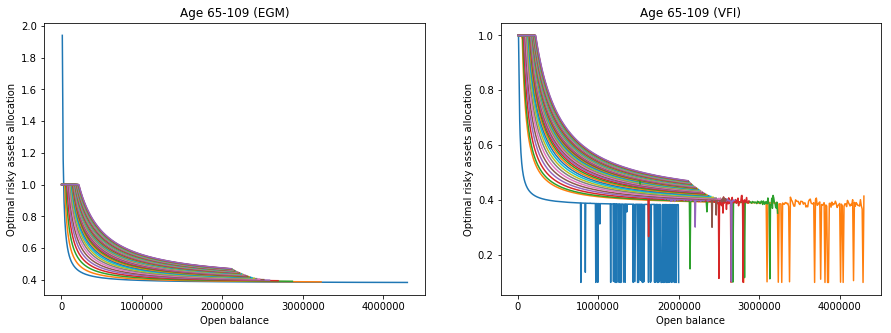

In [14]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
for i in range(0,45):
    plt.plot(Optimal_results_EGM.column(3*i+2), Optimal_θx.column(i)) #, label='age%1d_'%(108-i)
# plt.legend(loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal risky assets allocation')
plt.title('Age 65-109 (EGM)')

plt.subplot(1,2,2)
for i in range(0,45):
    plt.plot(Optimal_results_VFI.column(5*i+0), Optimal_θx_VFI.column(i)) #, label='age%1d_'%(108-i)
# plt.legend(loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal risky assets allocation')
plt.title('Age 65-109 (VFI)')

Text(0.5,1,'Age 65-105 (VFI)')

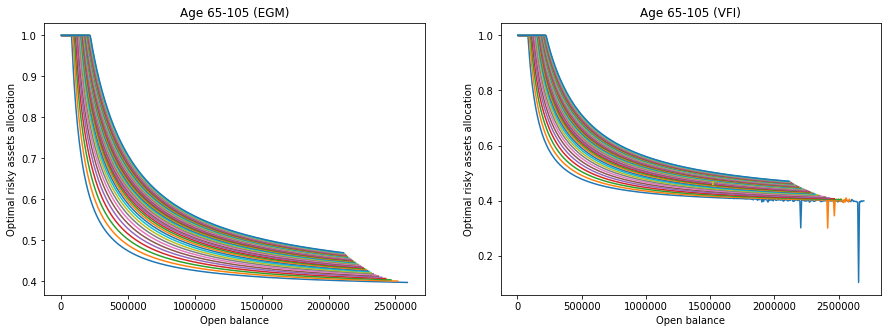

In [20]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
for i in range(4,45):
    plt.plot(Optimal_results_EGM.column(3*i+2), Optimal_θx.column(i)) #, label='age%1d_'%(108-i)
# plt.legend(loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal risky assets allocation')
plt.title('Age 65-105 (EGM)')

plt.subplot(1,2,2)
for i in range(4,45):
    plt.plot(Optimal_results_VFI.column(5*i+0), Optimal_θx_VFI.column(i)) #, label='age%1d_'%(108-i)
# plt.legend(loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal risky assets allocation')
plt.title('Age 65-105 (VFI)')

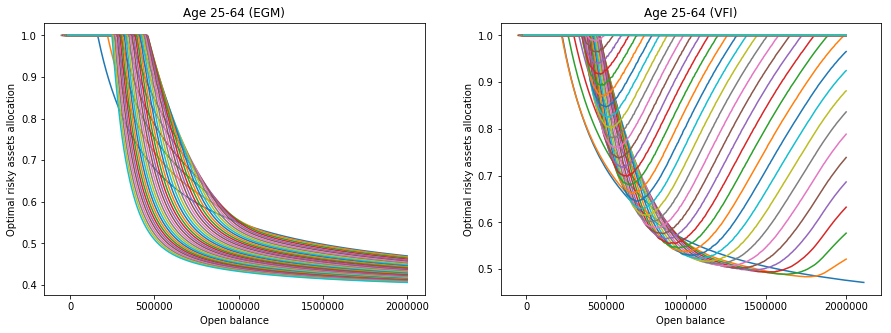

In [19]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
for i in range(40):
    plt.plot(Optimal_results_EGM_25_63.column(4*i+2), Optimal_θx_25_63.column(i)) #, label='age%1d_'%(108-i)
#     plt.pause(0.01)
#     time.sleep(1)
plt.xlabel('Open balance')
plt.ylabel('Optimal risky assets allocation')
plt.title('Age 25-64 (EGM)')

plt.subplot(1,2,2)
for i in range(40):
    plt.plot(Optimal_results_VFI_25_63.column(5*i+0), Optimal_θx_VFI_25_63.column(i)) #, label='age%1d_'%(108-i)
#     plt.pause(0.01)
#     time.sleep(1)
plt.xlabel('Open balance')
plt.ylabel('Optimal risky assets allocation')
plt.title('Age 25-64 (VFI)')

# plt.savefig('Portfolio choice (without leisure), 25-64 (400 grids).png')

In [29]:
Optimal_results_EGM_25_63.show(1)

A64,C64,M64,C_un64,A63,C63,M63,C_un63,A62,C62,M62,C_un62,A61,C61,M61,C_un61,A60,C60,M60,C_un60,A59,C59,M59,C_un59,A58,C58,M58,C_un58,A57,C57,M57,C_un57,A56,C56,M56,C_un56,A55,C55,M55,C_un55,A54,C54,M54,C_un54,A53,C53,M53,C_un53,A52,C52,M52,C_un52,A51,C51,M51,C_un51,A50,C50,M50,C_un50,A49,C49,M49,C_un49,A48,C48,M48,C_un48,A47,C47,M47,C_un47,A46,C46,M46,C_un46,A45,C45,M45,C_un45,A44,C44,M44,C_un44,A43,C43,M43,C_un43,A42,C42,M42,C_un42,A41,C41,M41,C_un41,A40,C40,M40,C_un40,A39,C39,M39,C_un39,A38,C38,M38,C_un38,A37,C37,M37,C_un37,A36,C36,M36,C_un36,A35,C35,M35,C_un35,A34,C34,M34,C_un34,A33,C33,M33,C_un33,A32,C32,M32,C_un32,A31,C31,M31,C_un31,A30,C30,M30,C_un30,A29,C29,M29,C_un29,A28,C28,M28,C_un28,A27,C27,M27,C_un27,A26,C26,M26,C_un26,A25,C25,M25,C_un25
5000,28733.7,-51266.3,28733.7,5000,32535.6,-47464.4,32535.6,5000,35681.7,-44318.3,35681.7,5000,38369.4,-41630.6,38369.4,5000,40703.1,-39296.9,40703.1,5000,42759,-37241,42759,5000,44604.9,-35395.1,44604.9,5000,46277.7,-33722.3,46277.7,5000,47804.9,-32195.1,47804.9,5000,49205.4,-30794.6,49205.4,5000,50493.7,-29506.3,50493.7,5000,51681.8,-28318.2,51681.8,5000,52779.6,-27220.4,52779.6,5000,53795.6,-26204.4,53795.6,5000,54737,-25263,54737,5000,55610.6,-24389.4,55610.6,5000,56422.5,-23577.5,56422.5,5000,57178.1,-22821.9,57178.1,5000,57882.9,-22117.1,57882.9,5000,58541.8,-21458.2,58541.8,5000,59159.3,-20840.7,59159.3,5000,59739.6,-20260.4,59739.6,5000,60286.7,-19713.3,60286.7,5000,60804,-19196,60804,5000,61294.8,-18705.2,61294.8,5000,61761.7,-18238.3,61761.7,5000,62207.4,-17792.6,62207.4,5000,62633.9,-17366.1,62633.9,5000,63043.3,-16956.7,63043.3,5000,63437.3,-16562.7,63437.3,5000,63817.2,-16182.8,63817.2,5000,64184.4,-15815.6,64184.4,5000,64540,-15460,64540,5000,64884.9,-15115.1,64884.9,5000,65220,-14780,65220,5000,65546.1,-14453.9,65546.1,5000,65863.7,-14136.3,65863.7,5000,66173.6,-13826.4,66173.6,5000,66476.3,-13523.7,66476.3,5000,66772.2,-13227.8,66772.2


In [30]:
Optimal_θx_25_63.show(1)

θ64,θ63,θ62,θ61,θ60,θ59,θ58,θ57,θ56,θ55,θ54,θ53,θ52,θ51,θ50,θ49,θ48,θ47,θ46,θ45,θ44,θ43,θ42,θ41,θ40,θ39,θ38,θ37,θ36,θ35,θ34,θ33,θ32,θ31,θ30,θ29,θ28,θ27,θ26,θ25
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [53]:
Optimal_results_VFI.show(1)

M110,C110,A110,V110,V110_adj,M109,C109,A109,V109,V109_adj,M108,C108,A108,V108,V108_adj,M107,C107,A107,V107,V107_adj,M106,C106,A106,V106,V106_adj,M105,C105,A105,V105,V105_adj,M104,C104,A104,V104,V104_adj,M103,C103,A103,V103,V103_adj,M102,C102,A102,V102,V102_adj,M101,C101,A101,V101,V101_adj,M100,C100,A100,V100,V100_adj,M99,C99,A99,V99,V99_adj,M98,C98,A98,V98,V98_adj,M97,C97,A97,V97,V97_adj,M96,C96,A96,V96,V96_adj,M95,C95,A95,V95,V95_adj,M94,C94,A94,V94,V94_adj,M93,C93,A93,V93,V93_adj,M92,C92,A92,V92,V92_adj,M91,C91,A91,V91,V91_adj,M90,C90,A90,V90,V90_adj,M89,C89,A89,V89,V89_adj,M88,C88,A88,V88,V88_adj,M87,C87,A87,V87,V87_adj,M86,C86,A86,V86,V86_adj,M85,C85,A85,V85,V85_adj,M84,C84,A84,V84,V84_adj,M83,C83,A83,V83,V83_adj,M82,C82,A82,V82,V82_adj,M81,C81,A81,V81,V81_adj,M80,C80,A80,V80,V80_adj,M79,C79,A79,V79,V79_adj,M78,C78,A78,V78,V78_adj,M77,C77,A77,V77,V77_adj,M76,C76,A76,V76,V76_adj,M75,C75,A75,V75,V75_adj,M74,C74,A74,V74,V74_adj,M73,C73,A73,V73,V73_adj,M72,C72,A72,V72,V72_adj,M71,C71,A71,V71,V71_adj,M70,C70,A70,V70,V70_adj,M69,C69,A69,V69,V69_adj,M68,C68,A68,V68,V68_adj,M67,C67,A67,V67,V67_adj,M66,C66,A66,V66,V66_adj,M65,C65,A65,V65,V65_adj
5000,35000,-30000,-1.66597e-19,35000,14058,38989.1,5068.98,-2.01203e-19,33386.9,12705.8,37664.1,5041.65,-3.22975e-19,29661.5,13063.1,38060.9,5002.23,-3.85966e-19,28369.3,13772.9,38813.2,4959.67,-4.1837e-19,27803.2,14552.6,39641.1,4911.48,-4.343e-19,27544.7,15303.8,40445.9,4858,-4.41686e-19,27428.8,15981.3,41185.5,4795.86,-4.45274e-19,27373.4,16580.2,41848.3,4731.88,-4.47002e-19,27346.9,17090.3,42423.9,4666.46,-4.48574e-19,27322.9,17502.6,42906.5,4596.08,-4.5131e-19,27281.4,17810.1,43291.2,4518.91,-4.56212e-19,27207.8,18047,43598.2,4448.74,-4.62081e-19,27121,18187.4,43812.9,4374.42,-4.70736e-19,26995.5,18215.7,43912.7,4303,-4.8354e-19,26814.9,18125.1,43893.4,4231.74,-5.01576e-19,26570.6,17915.7,43743.9,4171.82,-5.25762e-19,26259.6,17593.7,43478.4,4115.32,-5.56937e-19,25884.1,17170.4,43104.9,4065.55,-5.95874e-19,25450.5,16661.1,42644.8,4016.28,-6.43268e-19,24968.2,16084,42094.8,3989.16,-6.99661e-19,24449.1,15458.8,41493.4,3965.44,-7.65392e-19,23906.4,14802.8,40851.4,3951.36,-8.40808e-19,23351.3,14129.8,40189.3,3940.56,-9.26281e-19,22792.9,13451.2,39513.8,3937.49,-1.02218e-18,22238.4,12776.1,38830.5,3945.62,-1.12882e-18,21693.4,12111.5,38150.7,3960.85,-1.24648e-18,21162.4,11463.1,37487.3,3975.74,-1.3753e-18,20648.4,10834.9,36840.4,3994.55,-1.51535e-18,20153.8,10230.1,36213.2,4016.96,-1.66657e-18,19680.2,9650.76,35609.2,4041.59,-1.82877e-18,19228.5,9098.1,35014.2,4083.95,-2.00166e-18,18799.1,8572.73,34459.1,4113.66,-2.18487e-18,18392,8074.65,33911.4,4163.22,-2.37793e-18,18006.7,7603.38,33415.2,4188.2,-2.58036e-18,17642.7,7158.32,32926.9,4231.46,-2.79155e-18,17299.1,6738.76,32459.6,4279.2,-3.01079e-18,16975.2,6343.92,32033.5,4310.46,-3.23725e-18,16670.2,5972.93,31617,4355.88,-3.47007e-18,16383.3,5624.83,31229.1,4395.76,-3.7083e-18,16113.6,5298.62,30858.5,4440.1,-3.951e-18,15860.2,4993.18,30506.1,4487.04,-4.19724e-18,15622.3,4707.33,30184.2,4523.09,-4.44616e-18,15398.9,4439.81,29869.1,4570.76,-4.69698e-18,15189,4189.27,29581.7,4607.57,-4.94909e-18,14991.8,3954.33,29308,4646.29,-5.20199e-18,14806.2


In [ ]:
plt.subplot(4,2,8)
plt.plot(Optimal_results_EGM['M65'], Optimal_results_EGM['C65'])
plt.plot(Optimal_results_VFI['M65'], Optimal_results_VFI['C65'])
plt.legend(['EGM-65','VFI-65'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

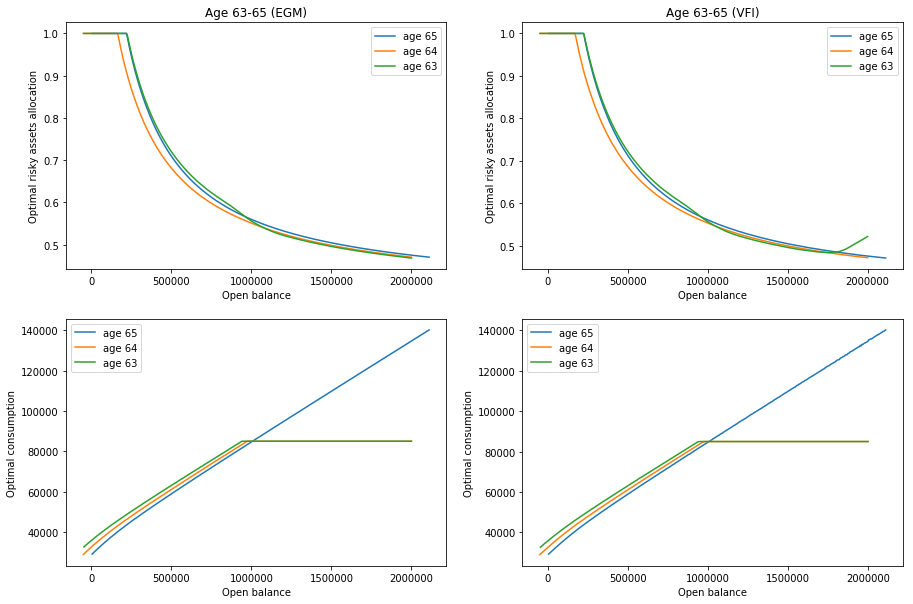

In [62]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(Optimal_results_EGM.column(3*44+2), Optimal_θx.column('θ65'), label='age 65')
for i in range(2):
    plt.plot(Optimal_results_EGM_25_63.column(4*i+2), Optimal_θx_25_63.column(i), label='age %1d'%(64-i))
plt.xlabel('Open balance')
plt.ylabel('Optimal risky assets allocation')
plt.legend()
plt.title('Age 63-65 (EGM)')

plt.subplot(2,2,2)
plt.plot(Optimal_results_VFI.column(5*44+0), Optimal_θx_VFI.column('θ65'), label='age 65')
for i in range(2):
    plt.plot(Optimal_results_VFI_25_63.column(5*i+5), Optimal_θx_VFI_25_63.column(i), label='age %1d'%(64-i))
plt.xlabel('Open balance')
plt.ylabel('Optimal risky assets allocation')
# plt.ylim((0,1.1))
plt.legend()
plt.title('Age 63-65 (VFI)')

plt.subplot(2,2,3)
plt.plot(Optimal_results_EGM['M65'], Optimal_results_EGM['C65'], label='age 65')
plt.plot(Optimal_results_EGM_25_63['M64'], Optimal_results_EGM_25_63['C64'], label='age 64')
plt.plot(Optimal_results_EGM_25_63['M63'], Optimal_results_EGM_25_63['C63'], label='age 63')
plt.legend(loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(2,2,4)
plt.plot(Optimal_results_VFI['M65'], Optimal_results_VFI['C65'], label='age 65')
plt.plot(Optimal_results_VFI_25_63['M64'], Optimal_results_VFI_25_63['C64'], label='age 64')
plt.plot(Optimal_results_VFI_25_63['M63'], Optimal_results_VFI_25_63['C63'], label='age 63')
plt.legend(loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

# plt.savefig('C&θ, 63-65.png')

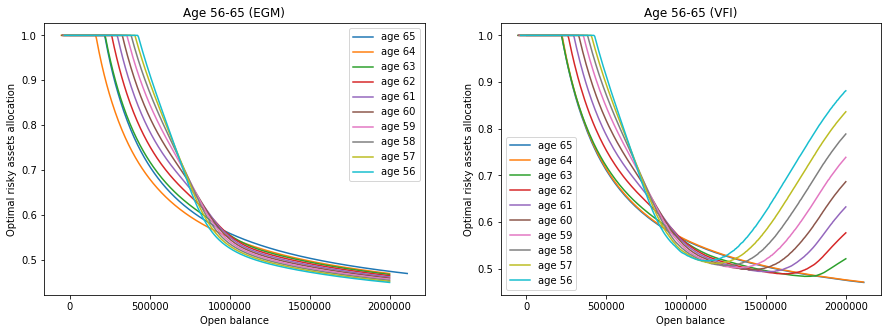

In [57]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(Optimal_results_EGM.column(3*44+2), Optimal_θx.column('θ65'), label='age 65')
for i in range(9):
    plt.plot(Optimal_results_EGM_25_63.column(4*i+2), Optimal_θx_25_63.column(i), label='age %1d'%(64-i)) #, label='age%1d_'%(108-i)
#     plt.pause(0.01)
#     time.sleep(1)
plt.xlabel('Open balance')
plt.ylabel('Optimal risky assets allocation')
plt.legend()
plt.title('Age 56-65 (EGM)')

plt.subplot(1,2,2)
plt.plot(Optimal_results_VFI.column(5*44+0), Optimal_θx_VFI.column('θ65'), label='age 65')
for i in range(9):
    plt.plot(Optimal_results_VFI_25_63.column(5*i+0), Optimal_θx_VFI_25_63.column(i), label='age %1d'%(64-i)) #, label='age%1d_'%(108-i)
plt.xlabel('Open balance')
plt.ylabel('Optimal risky assets allocation')
# plt.ylim((0,1.1))
plt.legend()
plt.title('Age 56-65 (VFI)')

# plt.savefig('Portfolio choice (EGM vs VFI), 56-65.png')

In [49]:
Optimal_results_EGM.show(1)

A109,C109,M109,A108,C108,M108,A107,C107,M107,A106,C106,M106,A105,C105,M105,A104,C104,M104,A103,C103,M103,A102,C102,M102,A101,C101,M101,A100,C100,M100,A99,C99,M99,A98,C98,M98,A97,C97,M97,A96,C96,M96,A95,C95,M95,A94,C94,M94,A93,C93,M93,A92,C92,M92,A91,C91,M91,A90,C90,M90,A89,C89,M89,A88,C88,M88,A87,C87,M87,A86,C86,M86,A85,C85,M85,A84,C84,M84,A83,C83,M83,A82,C82,M82,A81,C81,M81,A80,C80,M80,A79,C79,M79,A78,C78,M78,A77,C77,M77,A76,C76,M76,A75,C75,M75,A74,C74,M74,A73,C73,M73,A72,C72,M72,A71,C71,M71,A70,C70,M70,A69,C69,M69,A68,C68,M68,A67,C67,M67,A66,C66,M66,A65,C65,M65
5000,39058,14058,5000,37705.8,12705.8,5000,38063.1,13063.1,5000,38772.9,13772.9,5000,39552.6,14552.6,5000,40303.8,15303.8,5000,40981.3,15981.3,5000,41580.2,16580.2,5000,42090.3,17090.3,5000,42502.6,17502.6,5000,42810.1,17810.1,5000,43047,18047,5000,43187.4,18187.4,5000,43215.7,18215.7,5000,43125.1,18125.1,5000,42915.7,17915.7,5000,42593.7,17593.7,5000,42170.4,17170.4,5000,41661.1,16661.1,5000,41084,16084,5000,40458.8,15458.8,5000,39802.8,14802.8,5000,39129.8,14129.8,5000,38451.2,13451.2,5000,37776.1,12776.1,5000,37111.5,12111.5,5000,36463.1,11463.1,5000,35834.9,10834.9,5000,35230.1,10230.1,5000,34650.8,9650.76,5000,34098.1,9098.1,5000,33572.7,8572.73,5000,33074.6,8074.65,5000,32603.4,7603.38,5000,32158.3,7158.32,5000,31738.8,6738.76,5000,31343.9,6343.92,5000,30972.9,5972.93,5000,30624.8,5624.83,5000,30298.6,5298.62,5000,29993.2,4993.18,5000,29707.3,4707.33,5000,29439.8,4439.81,5000,29189.3,4189.27,5000,28954.3,3954.33


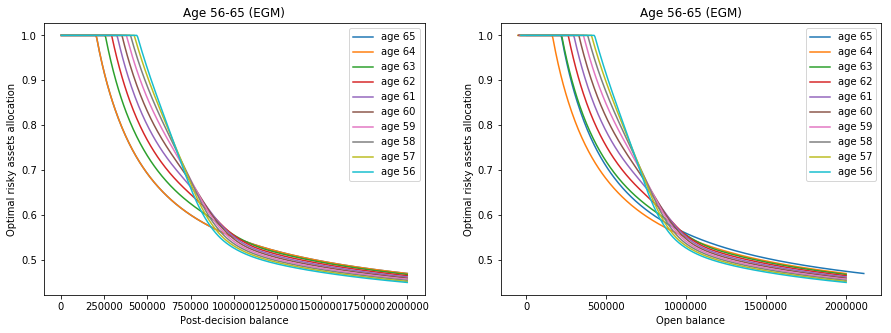

In [56]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(Optimal_results_EGM.column(3*44+0), Optimal_θx.column('θ65'), label='age 65')
for i in range(9):
    plt.plot(Optimal_results_EGM_25_63.column(4*i+0), Optimal_θx_25_63.column(i), label='age %1d'%(64-i)) #, label='age%1d_'%(108-i)
#     plt.pause(0.01)
#     time.sleep(1)
plt.xlabel('Post-decision balance')
plt.ylabel('Optimal risky assets allocation')
plt.legend()
plt.title('Age 56-65 (EGM)')

plt.subplot(1,2,2)
plt.plot(Optimal_results_EGM.column(3*44+2), Optimal_θx.column('θ65'), label='age 65')
for i in range(9):
    plt.plot(Optimal_results_EGM_25_63.column(4*i+2), Optimal_θx_25_63.column(i), label='age %1d'%(64-i)) #, label='age%1d_'%(108-i)
#     plt.pause(0.01)
#     time.sleep(1)
plt.xlabel('Open balance')
plt.ylabel('Optimal risky assets allocation')
plt.legend()
plt.title('Age 56-65 (EGM)')

# plt.savefig('Portfolio choice (Ax vs Mx), 56-65')

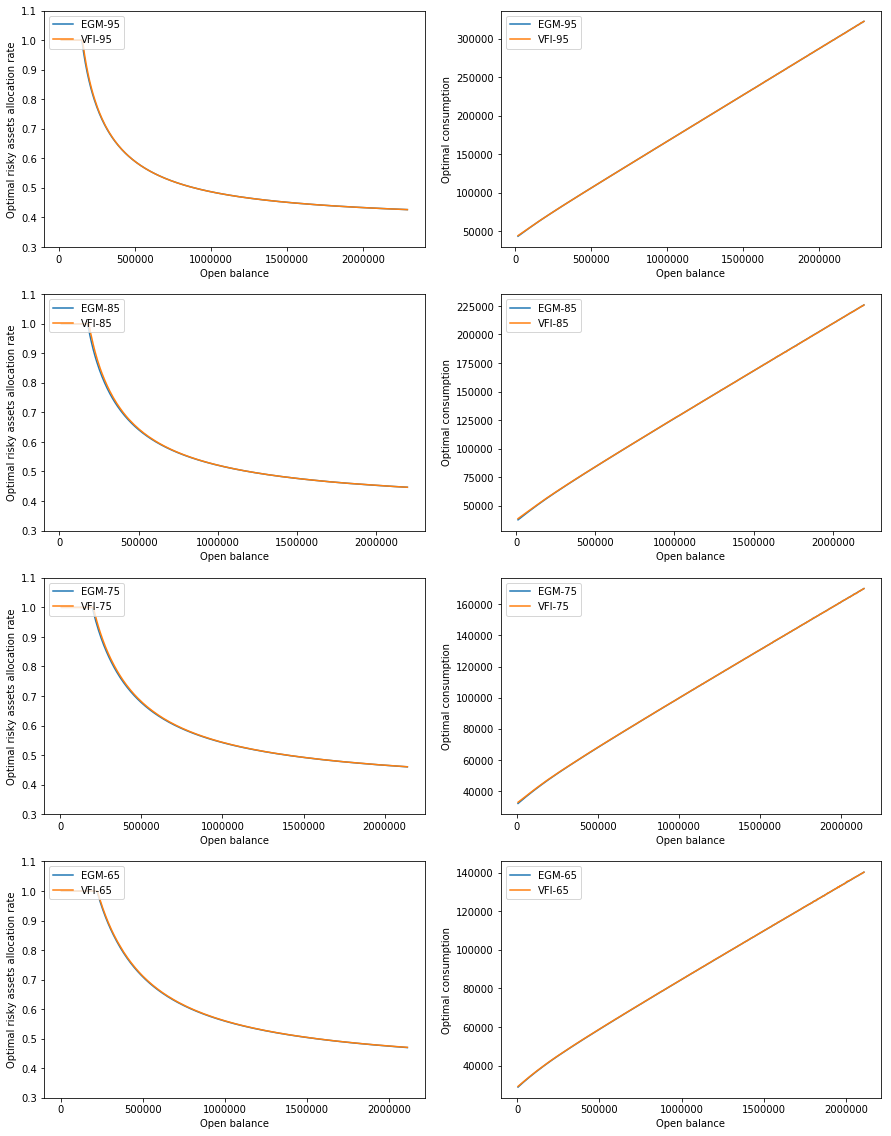

In [54]:
plt.figure(figsize=(15,20))

plt.subplot(4,2,1)
plt.plot(Optimal_results_EGM['M95'], Optimal_θx['θ95'])
plt.plot(Optimal_results_VFI['M95'], Optimal_θx_VFI['θ95'])
plt.legend(['EGM-95','VFI-95'], loc='upper left')
plt.ylim((0.3,1.1))
plt.xlabel('Open balance')
plt.ylabel('Optimal risky assets allocation rate')

plt.subplot(4,2,2)
plt.plot(Optimal_results_EGM['M95'], Optimal_results_EGM['C95'])
plt.plot(Optimal_results_VFI['M95'], Optimal_results_VFI['C95'])
plt.legend(['EGM-95','VFI-95'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,3)
plt.plot(Optimal_results_EGM['M85'], Optimal_θx['θ85'])
plt.plot(Optimal_results_VFI['M85'], Optimal_θx_VFI['θ85'])
plt.legend(['EGM-85','VFI-85'], loc='upper left')
plt.ylim((0.3,1.1))
plt.xlabel('Open balance')
plt.ylabel('Optimal risky assets allocation rate')

plt.subplot(4,2,4)
plt.plot(Optimal_results_EGM['M85'], Optimal_results_EGM['C85'])
plt.plot(Optimal_results_VFI['M85'], Optimal_results_VFI['C85'])
plt.legend(['EGM-85','VFI-85'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,5)
plt.plot(Optimal_results_EGM['M75'], Optimal_θx['θ75'])
plt.plot(Optimal_results_VFI['M75'], Optimal_θx_VFI['θ75'])
plt.legend(['EGM-75','VFI-75'], loc='upper left')
plt.ylim((0.3,1.1))
plt.xlabel('Open balance')
plt.ylabel('Optimal risky assets allocation rate')

plt.subplot(4,2,6)
plt.plot(Optimal_results_EGM['M75'], Optimal_results_EGM['C75'])
plt.plot(Optimal_results_VFI['M75'], Optimal_results_VFI['C75'])
plt.legend(['EGM-75','VFI-75'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,7)
plt.plot(Optimal_results_EGM['M65'], Optimal_θx['θ65'])
plt.plot(Optimal_results_VFI['M65'], Optimal_θx_VFI['θ65'])
plt.legend(['EGM-65','VFI-65'], loc='upper left')
plt.ylim((0.3,1.1))
plt.xlabel('Open balance')
plt.ylabel('Optimal risky assets allocation rate')

plt.subplot(4,2,8)
plt.plot(Optimal_results_EGM['M65'], Optimal_results_EGM['C65'])
plt.plot(Optimal_results_VFI['M65'], Optimal_results_VFI['C65'])
plt.legend(['EGM-65','VFI-65'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

# plt.savefig('C&θ, 65-95.png')

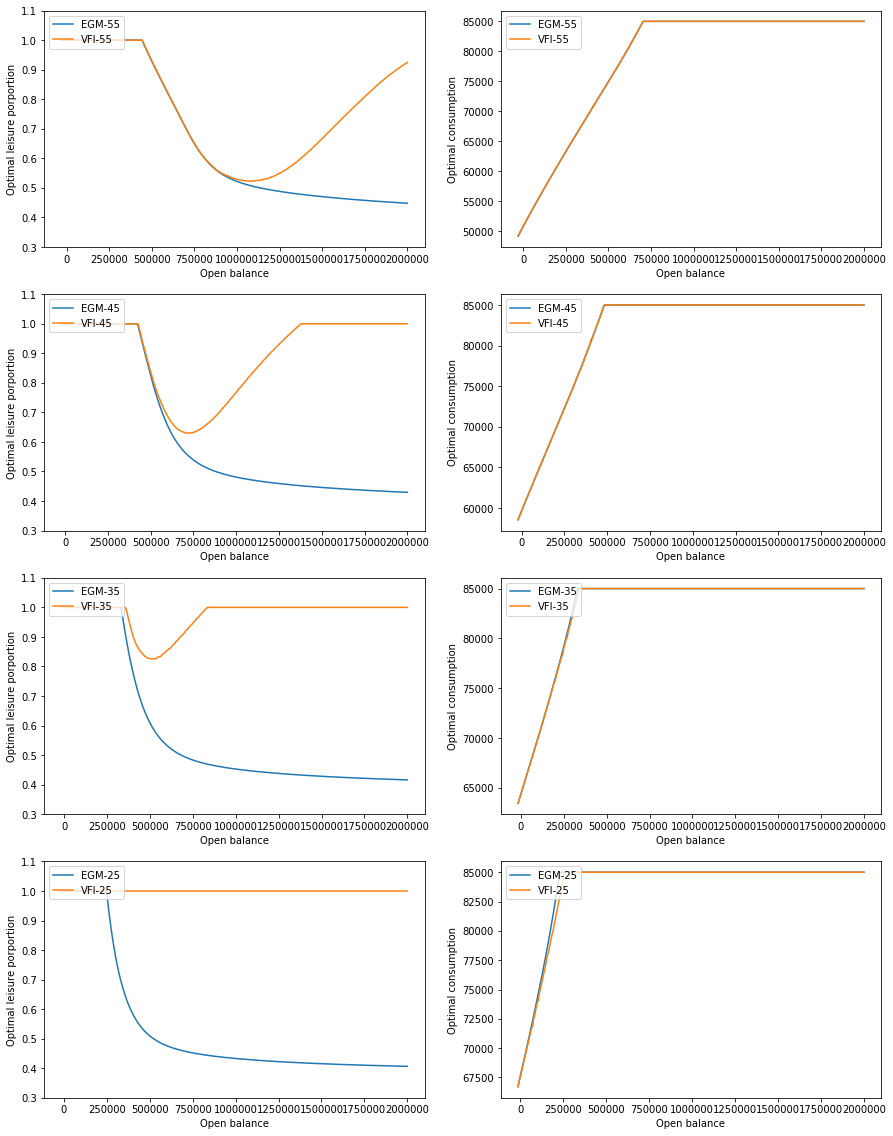

In [55]:
plt.figure(figsize=(15,20))

plt.subplot(4,2,1)
plt.plot(Optimal_results_EGM_25_63['M55'], Optimal_θx_25_63['θ55'])
plt.plot(Optimal_results_VFI_25_63['M55'], Optimal_θx_VFI_25_63['θ55'])
plt.legend(['EGM-55','VFI-55'], loc='upper left')
plt.ylim((0.3,1.1))
plt.xlabel('Open balance')
plt.ylabel('Optimal leisure porportion')

plt.subplot(4,2,2)
plt.plot(Optimal_results_EGM_25_63['M55'], Optimal_results_EGM_25_63['C55'])
plt.plot(Optimal_results_VFI_25_63['M55'], Optimal_results_VFI_25_63['C55'])
plt.legend(['EGM-55','VFI-55'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,3)
plt.plot(Optimal_results_EGM_25_63['M45'], Optimal_θx_25_63['θ45'])
plt.plot(Optimal_results_VFI_25_63['M45'], Optimal_θx_VFI_25_63['θ45'])
plt.legend(['EGM-45','VFI-45'], loc='upper left')
plt.ylim((0.3,1.1))
plt.xlabel('Open balance')
plt.ylabel('Optimal leisure porportion')

plt.subplot(4,2,4)
plt.plot(Optimal_results_EGM_25_63['M45'], Optimal_results_EGM_25_63['C45'])
plt.plot(Optimal_results_VFI_25_63['M45'], Optimal_results_VFI_25_63['C45'])
plt.legend(['EGM-45','VFI-45'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,5)
plt.plot(Optimal_results_EGM_25_63['M35'], Optimal_θx_25_63['θ35'])
plt.plot(Optimal_results_VFI_25_63['M35'], Optimal_θx_VFI_25_63['θ35'])
plt.legend(['EGM-35','VFI-35'], loc='upper left')
plt.ylim((0.3,1.1))
plt.xlabel('Open balance')
plt.ylabel('Optimal leisure porportion')

plt.subplot(4,2,6)
plt.plot(Optimal_results_EGM_25_63['M35'], Optimal_results_EGM_25_63['C35'])
plt.plot(Optimal_results_VFI_25_63['M35'], Optimal_results_VFI_25_63['C35'])
plt.legend(['EGM-35','VFI-35'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,7)
plt.plot(Optimal_results_EGM_25_63['M25'], Optimal_θx_25_63['θ25'])
plt.plot(Optimal_results_VFI_25_63['M25'], Optimal_θx_VFI_25_63['θ25'])
plt.legend(['EGM-25','VFI-25'], loc='upper left')
plt.ylim((0.3,1.1))
plt.xlabel('Open balance')
plt.ylabel('Optimal leisure porportion')

plt.subplot(4,2,8)
plt.plot(Optimal_results_EGM_25_63['M25'], Optimal_results_EGM_25_63['C25'])
plt.plot(Optimal_results_VFI_25_63['M25'], Optimal_results_VFI_25_63['C25'])
plt.legend(['EGM-25','VFI-25'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

# plt.savefig('C&θ, 25-55.png')

Text(0,0.5,'Optimal consumption')

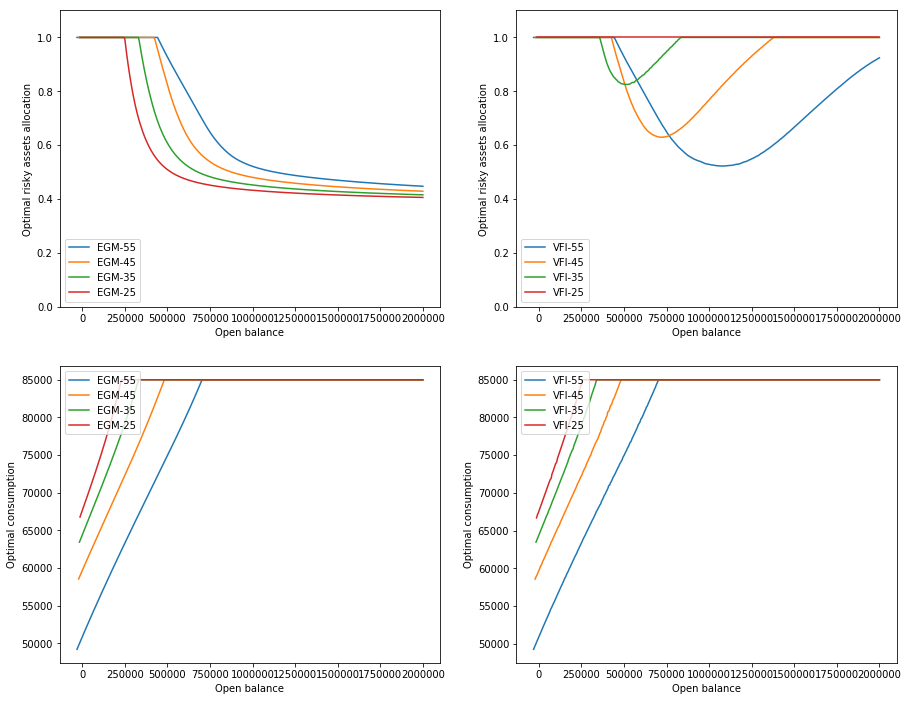

In [24]:
plt.figure(figsize=(15,12))

plt.subplot(2,2,1)
plt.plot(Optimal_results_EGM_25_63['M55'], Optimal_θx_25_63['θ55'])
# plt.plot(Optimal_results_VFI_25_63['M55'], Optimal_θx_VFI_25_63['θ55'])
plt.plot(Optimal_results_EGM_25_63['M45'], Optimal_θx_25_63['θ45'])
# plt.plot(Optimal_results_VFI_25_63['M45'], Optimal_θx_VFI_25_63['θ45'])
plt.plot(Optimal_results_EGM_25_63['M35'], Optimal_θx_25_63['θ35'])
# plt.plot(Optimal_results_VFI_25_63['M35'], Optimal_θx_VFI_25_63['θ35'])
plt.plot(Optimal_results_EGM_25_63['M25'], Optimal_θx_25_63['θ25'])
# plt.plot(Optimal_results_VFI_25_63['M25'], Optimal_θx_VFI_25_63['θ25'])
plt.legend(['EGM-55','EGM-45','EGM-35','EGM-25',], loc='lower left')
plt.ylim((0,1.1))
plt.xlabel('Open balance')
plt.ylabel('Optimal risky assets allocation')

plt.subplot(2,2,2)
# plt.plot(Optimal_results_EGM_25_63['M55'], Optimal_θx_25_63['θ55'])
plt.plot(Optimal_results_VFI_25_63['M55'], Optimal_θx_VFI_25_63['θ55'])
# plt.plot(Optimal_results_EGM_25_63['M45'], Optimal_θx_25_63['θ45'])
plt.plot(Optimal_results_VFI_25_63['M45'], Optimal_θx_VFI_25_63['θ45'])
# plt.plot(Optimal_results_EGM_25_63['M35'], Optimal_θx_25_63['θ35'])
plt.plot(Optimal_results_VFI_25_63['M35'], Optimal_θx_VFI_25_63['θ35'])
# plt.plot(Optimal_results_EGM_25_63['M25'], Optimal_θx_25_63['θ25'])
plt.plot(Optimal_results_VFI_25_63['M25'], Optimal_θx_VFI_25_63['θ25'])
plt.legend(['VFI-55','VFI-45','VFI-35','VFI-25',], loc='lower left')
plt.ylim((0,1.1))
plt.xlabel('Open balance')
plt.ylabel('Optimal risky assets allocation')


plt.subplot(2,2,3)
plt.plot(Optimal_results_EGM_25_63['M55'], Optimal_results_EGM_25_63['C55'])
# plt.plot(Optimal_results_VFI_25_63['M55'], Optimal_results_VFI_25_63['C55'])
plt.plot(Optimal_results_EGM_25_63['M45'], Optimal_results_EGM_25_63['C45'])
# plt.plot(Optimal_results_VFI_25_63['M45'], Optimal_results_VFI_25_63['C45'])
plt.plot(Optimal_results_EGM_25_63['M35'], Optimal_results_EGM_25_63['C35'])
# plt.plot(Optimal_results_VFI_25_63['M35'], Optimal_results_VFI_25_63['C35'])
plt.plot(Optimal_results_EGM_25_63['M25'], Optimal_results_EGM_25_63['C25'])
# plt.plot(Optimal_results_VFI_25_63['M25'], Optimal_results_VFI_25_63['C25'])
plt.legend(['EGM-55','EGM-45','EGM-35','EGM-25',], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(2,2,4)
# plt.plot(Optimal_results_EGM_25_63['M55'], Optimal_results_EGM_25_63['C55'])
plt.plot(Optimal_results_VFI_25_63['M55'], Optimal_results_VFI_25_63['C55'])
# plt.plot(Optimal_results_EGM_25_63['M45'], Optimal_results_EGM_25_63['C45'])
plt.plot(Optimal_results_VFI_25_63['M45'], Optimal_results_VFI_25_63['C45'])
# plt.plot(Optimal_results_EGM_25_63['M35'], Optimal_results_EGM_25_63['C35'])
plt.plot(Optimal_results_VFI_25_63['M35'], Optimal_results_VFI_25_63['C35'])
# plt.plot(Optimal_results_EGM_25_63['M25'], Optimal_results_EGM_25_63['C25'])
plt.plot(Optimal_results_VFI_25_63['M25'], Optimal_results_VFI_25_63['C25'])
plt.legend(['VFI-55','VFI-45','VFI-35','VFI-25',], loc='upper left')
# plt.ylim((0,1.1))
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')


plt.savefig('C&θ,25-65.png')

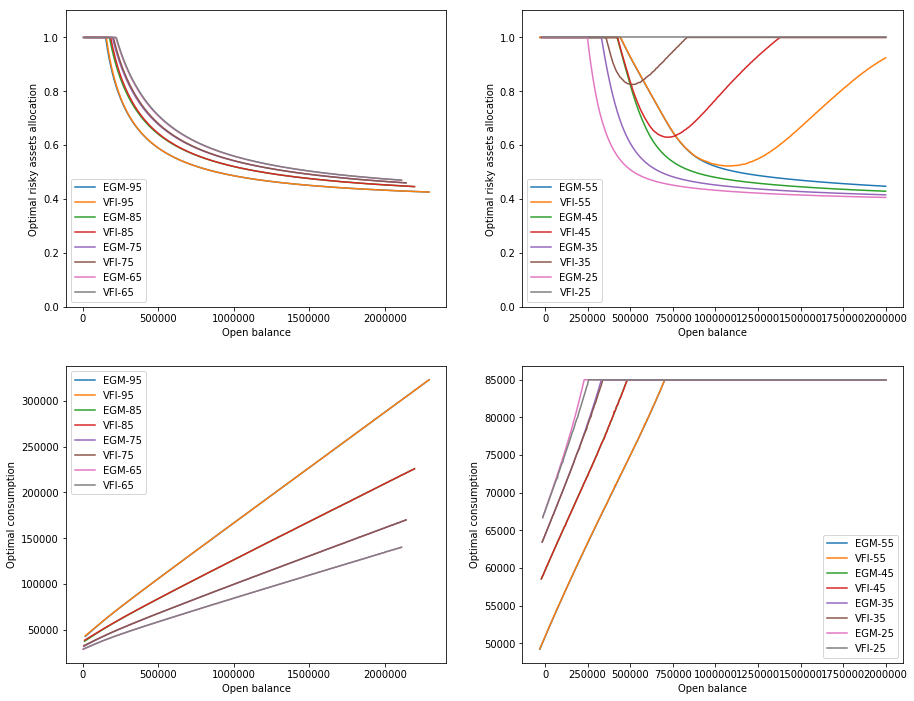

In [28]:
plt.figure(figsize=(15,12))

plt.subplot(2,2,1)
plt.plot(Optimal_results_EGM['M95'], Optimal_θx['θ95'])
plt.plot(Optimal_results_VFI['M95'], Optimal_θx_VFI['θ95'])
plt.plot(Optimal_results_EGM['M85'], Optimal_θx['θ85'])
plt.plot(Optimal_results_VFI['M85'], Optimal_θx_VFI['θ85'])
plt.plot(Optimal_results_EGM['M75'], Optimal_θx['θ75'])
plt.plot(Optimal_results_VFI['M75'], Optimal_θx_VFI['θ75'])
plt.plot(Optimal_results_EGM['M65'], Optimal_θx['θ65'])
plt.plot(Optimal_results_VFI['M65'], Optimal_θx_VFI['θ65'])
plt.legend(['EGM-95','VFI-95','EGM-85','VFI-85','EGM-75','VFI-75','EGM-65','VFI-65',], loc='lower left')
plt.ylim((0,1.1))
plt.xlabel('Open balance')
plt.ylabel('Optimal risky assets allocation')

plt.subplot(2,2,2)
plt.plot(Optimal_results_EGM_25_63['M55'], Optimal_θx_25_63['θ55'])
plt.plot(Optimal_results_VFI_25_63['M55'], Optimal_θx_VFI_25_63['θ55'])
plt.plot(Optimal_results_EGM_25_63['M45'], Optimal_θx_25_63['θ45'])
plt.plot(Optimal_results_VFI_25_63['M45'], Optimal_θx_VFI_25_63['θ45'])
plt.plot(Optimal_results_EGM_25_63['M35'], Optimal_θx_25_63['θ35'])
plt.plot(Optimal_results_VFI_25_63['M35'], Optimal_θx_VFI_25_63['θ35'])
plt.plot(Optimal_results_EGM_25_63['M25'], Optimal_θx_25_63['θ25'])
plt.plot(Optimal_results_VFI_25_63['M25'], Optimal_θx_VFI_25_63['θ25'])
plt.legend(['EGM-55','VFI-55','EGM-45','VFI-45','EGM-35','VFI-35','EGM-25','VFI-25',], loc='lower left')
plt.ylim((0,1.1))
plt.xlabel('Open balance')
plt.ylabel('Optimal risky assets allocation')


plt.subplot(2,2,3)
plt.plot(Optimal_results_EGM['M95'], Optimal_results_EGM['C95'])
plt.plot(Optimal_results_VFI['M95'], Optimal_results_VFI['C95'])
plt.plot(Optimal_results_EGM['M85'], Optimal_results_EGM['C85'])
plt.plot(Optimal_results_VFI['M85'], Optimal_results_VFI['C85'])
plt.plot(Optimal_results_EGM['M75'], Optimal_results_EGM['C75'])
plt.plot(Optimal_results_VFI['M75'], Optimal_results_VFI['C75'])
plt.plot(Optimal_results_EGM['M65'], Optimal_results_EGM['C65'])
plt.plot(Optimal_results_VFI['M65'], Optimal_results_VFI['C65'])
plt.legend(['EGM-95','VFI-95','EGM-85','VFI-85','EGM-75','VFI-75','EGM-65','VFI-65',], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(2,2,4)
plt.plot(Optimal_results_EGM_25_63['M55'], Optimal_results_EGM_25_63['C55'])
plt.plot(Optimal_results_VFI_25_63['M55'], Optimal_results_VFI_25_63['C55'])
plt.plot(Optimal_results_EGM_25_63['M45'], Optimal_results_EGM_25_63['C45'])
plt.plot(Optimal_results_VFI_25_63['M45'], Optimal_results_VFI_25_63['C45'])
plt.plot(Optimal_results_EGM_25_63['M35'], Optimal_results_EGM_25_63['C35'])
plt.plot(Optimal_results_VFI_25_63['M35'], Optimal_results_VFI_25_63['C35'])
plt.plot(Optimal_results_EGM_25_63['M25'], Optimal_results_EGM_25_63['C25'])
plt.plot(Optimal_results_VFI_25_63['M25'], Optimal_results_VFI_25_63['C25'])
plt.legend(['EGM-55','VFI-55','EGM-45','VFI-45','EGM-35','VFI-35','EGM-25','VFI-25',], loc='lower right')
# plt.ylim((0,1.1))
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')


# plt.savefig('C&θ,25-95.png')